# S2W7D3: 评价指标与模型体检 (Metrics & Evaluation)

昨天我们看着 Loss 从 1.3 降到了 0.6，这很爽，但也很**虚**。
因为 Loss 只是给机器用来求梯度的数字，它并不能直接回答老板或面试官的问题：**“你的模型准确率到底有多少？能不能上线？”**

今天我们的任务就是把这个“黑盒”打开，用工业界的标准指标（Accuracy, F1-Score, Confusion Matrix）来量化模型的表现。同时，我们要解决真实的具身智能场景中必遇到的\*\*“类别不平衡”\*\*问题。

## 1 🛠️ 核心代码：封装评价指标

为了保持`train.py`的简洁，我们将评价逻辑封装在`src`中，**文件路径**: `project_root/src/metrics.py`。

```python
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def compute_metrics(eval_pred):
    """
    Hugging Face Trainer 专用的回调函数
    :param eval_pred: 包含 (logits, labels) 的元组
    """
    logits, labels = eval_pred
    
    # 1. 获取预测类别 (Argmax)
    # logits shape: [batch_size, num_labels] -> predictions shape: [batch_size]
    predictions = np.argmax(logits, axis=-1)
    
    # 2. 计算基础指标
    acc = accuracy_score(labels, predictions)
    
    # 3. 计算 F1-Score (加权平均)
    # 'weighted': 考虑类别不平衡，样本多的类别权重高
    # 'macro': 不考虑样本数量，所有类别平等（适合关注少数类）
    f1 = f1_score(labels, predictions, average='weighted')
    precision = precision_score(labels, predictions, average='weighted')
    recall = recall_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }
```

## 2 💻 笔记本实战：加载模型并评估

我们不需要重新训练模型，而是直接**加载昨天训练好的Checkpoint**进行评估。这模拟了“模型上线前的验收环节”。

### 2.1 环境准备与加载模型

In [1]:
import sys
sys.path.append("../../") 

import torch
from transformers import Trainer, TrainingArguments, BertTokenizer
from src.config import PRETRAINED_MODEL_DIR, CHECKPOINT_DIR
from src.models.model_bert import BertClassifier
from src.dataset.dataset import IntentDataset
from src.metrics import compute_metrics # 导入刚才写的函数

# 1. 重新准备验证数据 (这次我们要看验证集表现)
# 假设 0:移动, 1:停止, 2:操作
val_texts = ["向左转", "停止", "抓起来", "请勿移动", "前进"]
val_labels = [0, 1, 2, 1, 0]

tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_DIR)
val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

# 2. 加载昨天训练好的最佳 Checkpoint
# 注意：请去 output/train/checkpoints/ 目录下看一眼，找那个数字最大的文件夹，比如 checkpoint-24
best_checkpoint_path = str(CHECKPOINT_DIR / "checkpoint-24") 
print(f"正在加载模型: {best_checkpoint_path}")

model = BertClassifier(model_path=PRETRAINED_MODEL_DIR, num_labels=3)
# 加载微调后的权重 (关键步骤！)
# 注意：因为我们是自定义模型类，不能直接 .from_pretrained(checkpoint_path)
# 我们需要手动加载 state_dict
# state_dict = torch.load(f"{best_checkpoint_path}/model.safetensors") # 或者 pytorch_model.bin
# 如果是 safetensors 格式，可能需要用 safetensors 库加载，或者 trainer 自动保存的是 bin
# 这里假设 Trainer 保存的是 safetensors (根据你昨天的截图)
from safetensors.torch import load_file
state_dict = load_file(f"{best_checkpoint_path}/model.safetensors")

model.load_state_dict(state_dict)
print("✅ 模型权重加载完毕！")

正在加载模型: /home/goodminton/study/AI-Interview-Sprint/output/train/checkpoints/checkpoint-24
✅ 模型权重加载完毕！


### 2.2 运行评估 (Evaluate)

In [2]:
# 3. 初始化 Trainer (仅用于评估)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=4,
    do_train=False,
    do_eval=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics, # ★ 把我们的函数挂载上去
)

# 4. 开始评估
print("正在评估...")
metrics = trainer.evaluate()

print("-" * 30)
print(f"评估结果: {metrics}")
# 重点关注 'eval_accuracy' 和 'eval_f1'

正在评估...


------------------------------
评估结果: {'eval_loss': 0.9212514758110046, 'eval_model_preparation_time': 0.0048, 'eval_accuracy': 0.6, 'eval_f1': 0.5333333333333333, 'eval_precision': 0.6, 'eval_recall': 0.6, 'eval_runtime': 0.8757, 'eval_samples_per_second': 5.709, 'eval_steps_per_second': 2.284}


/home/goodminton/anaconda3/envs/utils/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## 3 📊 进阶分析：混淆矩阵 (Confusion Matrix)

只看 Accuracy 是不够的。如果你的机器人把“紧急停止”预测成了“前进”，那是重大事故。我们需要看**混淆矩阵**。

/home/goodminton/anaconda3/envs/utils/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


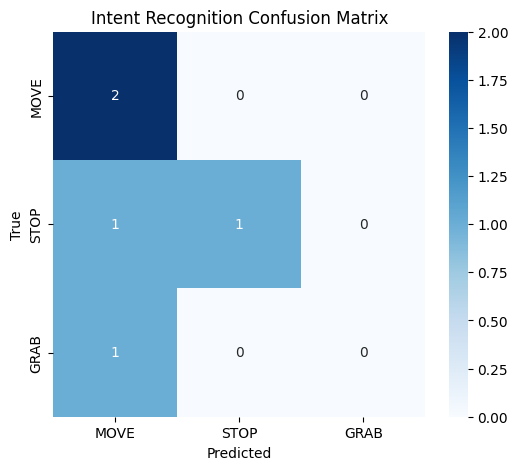

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. 手动跑一遍预测
predictions = trainer.predict(val_dataset)
pred_ids = np.argmax(predictions.predictions, axis=-1)
true_ids = predictions.label_ids

# 2. 计算混淆矩阵
cm = confusion_matrix(true_ids, pred_ids)

# 3. 画图
label_map = {0: "MOVE", 1: "STOP", 2: "GRAB"}
labels = [label_map[i] for i in range(3)]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Intent Recognition Confusion Matrix')
plt.show()

**🔍 如何看图 (面试必问)**：

  * **对角线**上的数字越大越好（预测正确）。
  * **非对角线**上的数字代表**误判**。
      * 例如：True="STOP" 行，Predicted="MOVE" 列如果有数字，说明\*\*“本来该停，结果动了”\*\* -\> **极度危险 (Critical Failure)**。

## 4 💥 痛点解决：类别不平衡 (Class Imbalance)

**场景**：
在具身智能数据中，`MOVE` 指令可能占 90%，`STOP` 只有 5%。
如果模型全部预测 `MOVE`，Accuracy 依然有 90%，但 `STOP` 类别的 Recall 是 0%。

**解决方案：Weighted Loss (加权损失)**

我们需要修改 `src/models/model_bert.py`。这是**加分项**，如果今天时间不够可以只看不写，但面试要会说。

```python
# 修改 src/models/model_bert.py 中的 Loss 计算部分

def __init__(self, ...):
    # 假设 MOVE(0) 很多，STOP(1) 很少
    # 给 STOP 更高的权重 (比如 5倍)
    class_weights = torch.tensor([1.0, 5.0, 1.0]).to(device)
    self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)

def forward(self, ...):
    # ...
    if labels is not None:
        loss = self.loss_fct(logits.view(-1, ...), labels.view(-1))
```

**原理**：如果模型把“贵重”的样本（STOP）预测错了，Loss 会爆炸，逼迫模型重点学习它。

## 5\. ⚔️ 每日算法题 (LeetCode 16)

昨天是**双指针**解决回文串，今天我们升级到**三指针**（其实是排序+双指针）。

### 5.1 🎯 题目: [LeetCode 16. 最接近的三数之和 (3Sum Closest)](../../LeetCode%20practice/1-50.ipynb)

  * **难度**: Medium
  * **标签**: 数组、双指针、排序
  * **描述**:
      给你一个长度为 `n` 的整数数组 `nums` 和一个目标值 `target`。请你从 `nums` 中选出三个整数，使它们的和与 `target` 最接近。
      返回这三个数的和。
      * 示例: `nums = [-1, 2, 1, -4], target = 1`
      * 输出: `2` (因为 `(-1 + 2 + 1 = 2)` 与 `1` 最接近)。
### 5.2 🧠 解题提示 (不直接给代码)

1.  **第一步**: 还是先 **排序** (`nums.sort()`)。没有排序，双指针就失效了。
2.  **第二步**: 固定第一个数 `nums[i]`。
3.  **第三步**: 使用双指针 `left` (在 `i+1`) 和 `right` (在 `n-1`)。
    * 计算 `current_sum = nums[i] + nums[left] + nums[right]`。
    * **关键逻辑**:
        * 如果 `current_sum` 比 `target` 大，说明要变小一点 -> `right` 左移。
        * 如果 `current_sum` 比 `target` 小，说明要变大一点 -> `left` 右移。
        * **时刻记录**: 如果当前的差距 `abs(current_sum - target)` 比我们要找的 `min_diff` 还要小，就更新全局的 `closest_sum`。



### ✅ Day 3 任务清单

1.  **编写 `src/metrics.py`**：实现 `compute_metrics`。
2.  **运行 Notebook**：加载 Checkpoint-24，运行 `trainer.evaluate()`，看到 Accuracy 和 F1 分数。
3.  **可视化**：画出混淆矩阵，分析模型在哪个类别上容易犯错。
4.  **算法**: 通过 LeetCode 15。

**Start?** 如果准备好了，请回复 **“Start Day 3”**，我们先搞定 `metrics.py`！